# Luzon Monthly Peak Electricity Demand 2008-2022

This notebook contains time series analysis and forecasting of the Luzon monthly peak electricity demand from years 2008-2022. This means that we have a total of 15 years of monthly data in our hand. <br>

After performing some analysis on the time series we are going to try various forecasting models and see how they perform relative to each other. The models that we're going to try are: <br>
  * ETS models
  * ARIMA models
  
  <br>
  
The data from this notebook can be obtained from the NGCP website. <br>
https://www.ngcp.ph/operations#operations

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from pathlib import os

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["font.size"] = 12


In [2]:
file = "Luzon_monthly_peak.csv"
path = os.path.join(os.path.realpath(".."), "datasets", file)

ts = pd.read_csv(path, dtype="float")["mw_peak"]
dates = pd.date_range("2008-01-01", "2022-12-01", freq="MS")
ts.index = dates
ts

2008-01-01     5972.0
2008-02-01     6094.0
2008-03-01     6211.0
2008-04-01     6663.0
2008-05-01     6485.0
               ...   
2022-08-01    11277.0
2022-09-01    11469.0
2022-10-01    11282.0
2022-11-01    10989.0
2022-12-01    10844.0
Freq: MS, Name: mw_peak, Length: 180, dtype: float64

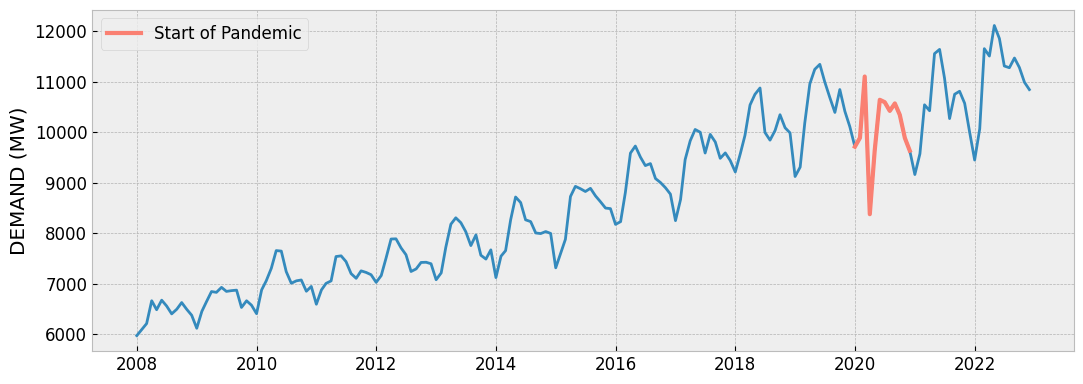

In [3]:
plt.plot(ts)
plt.plot(ts[ts.index.year == 2020], label="Start of Pandemic", color="salmon", linewidth=3)

ax = plt. gca()
ax.set_ylabel("DEMAND (MW)")
plt.legend()
plt.tight_layout()
plt.show()

We see that the trend is roughly linear and we see that the seasonal variation over time increases, we need to take into account these two factors when we start building our models <br>
A glaring problem in the time series is seen in the year 2020, where the start of the pandemic began. We see a drastic drop in demand and its shape is uncomparable to nearby years. We have to perform some processing so that this outlier event does not significantly harm the perfomance of our models later.

In [4]:
from sklearn.metrics import mean_absolute_percentage_error as mape

ts_train = ts.iloc[:-12]
ts_test = ts.iloc[-12:]

### ETS models

In [11]:
# Fit a multiplicative error, additive trend, and multiplicative seasonality on the train set

ets_MAM = ETSModel(ts_train,
                   error="mul",
                   trend="Add",
                   damped_trend=False,
                   seasonal="mul",
                   seasonal_periods=12)

fit_MAM = ets_MAM.fit()
MAM_fore12 = fit_MAM.forecast(12)
MAM_fore36 = fit_MAM.forecast(36)
fit_MAM.pvalues

0     4.087325e-09
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
dtype: float64

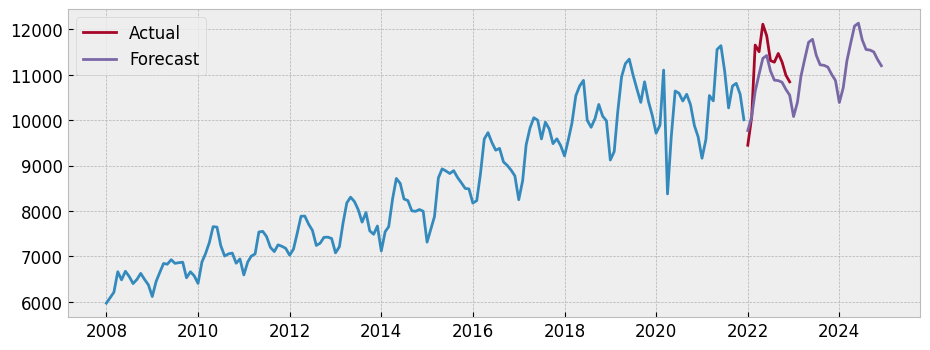

In [6]:
def plot_fore(train, test=None, forecast=None, inv_log=False):
    if inv_log:
        train = np.e ** train
        test = np.e ** test
        forecast = np.e ** forecast
        
    plt.plot(train)
    if test is not None:
        plt.plot(test, label="Actual")
    if forecast is not None:
        plt.plot(forecast, label="Forecast")
    plt.legend()
    
plot_fore(ts_train, ts_test, MAM_fore36)

We see that the model noticeably produced under-forecasts which can be attributed to the anomaly in 2020. <br> Since the anomaly occured near the end of the time series, we cannot simply drop it.

<AxesSubplot: >

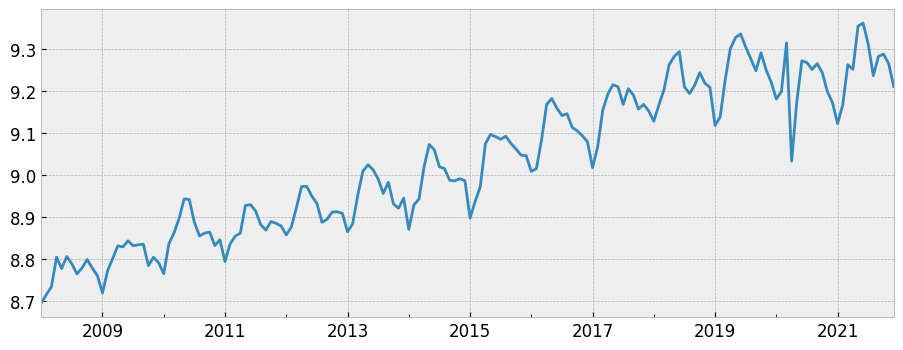

In [122]:
# Perform log transform
ts_train_log = np.log(ts_train)
ts_test_log = np.log(ts_test)
ts_train_log.plot()

We see that after the log transformation, we've somewhat reduced the variance over time.

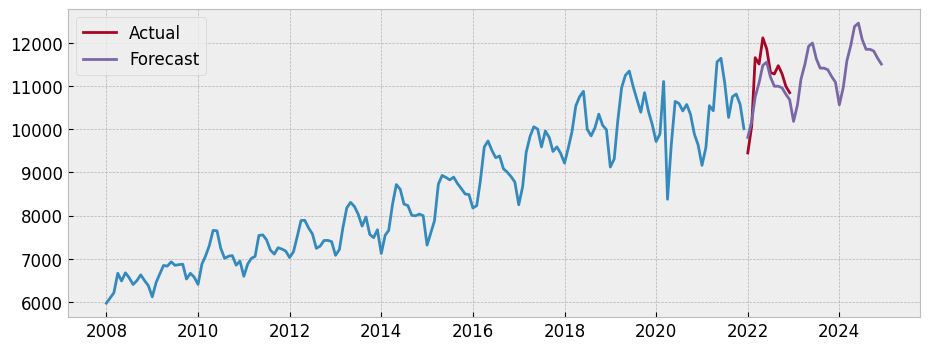

In [123]:
ets_MAM_log = ETSModel(ts_train_log,
                   error="mul",
                   trend="Add",
                   damped_trend=False,
                   seasonal="mul",
                   seasonal_periods=12)

ets_MAM_log_model = ets_MAM_log.fit()
ets_MAM_log_fore = ets_MAM_log_model.forecast(36)
plot_fore(ts_train_log, ts_test_log, ets_MAM_log_fore, True)

The log transformation didn't help that much, let's try an automated process to pick the best ETS model.


In [112]:
from sktime.forecasting.ets import AutoETS
ts_train_log_pi = ts_train_log.copy()
ts_train_log_pi.index = pd.PeriodIndex(ts_train_log.index, freq="M") 

auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(ts_train_log_pi)
auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                mw_peak   No. Observations:                  168
Model:                       ETS(MAM)   Log Likelihood                 338.747
Date:                Sun, 06 Aug 2023   AIC                           -641.495
Time:                        21:53:10   BIC                           -585.263
Sample:                    01-31-2008   HQIC                          -618.673
                         - 12-31-2021   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3381      0.070      4.799      0.000       0.200       0.476
smoothing_trend      3.381e-05        nan        nan        nan         nan         nan
smoothing_seasonal   6.619e-05        nan        nan        nan         nan         nan
initial_level           8.6726     27.958      0.310      0.756     -46.124      63.469
initial_trend           0.0031      0.010      0.309      0.757      -0.017       0.023
initial_seasonal.0      1.0055      3.242      0.310      0.756      -5.348       7.359
initial_seasonal.1      1.0071      3.247      0.310      0.756      -5.356       7.371
initial_seasonal.2      1.0090      3.253      0.310      0.756      -5.366       7.384
initial_seasonal.3      1.0097      3.255      0.310      0.756      -5.370       7.389
initial_seasonal.4      1.0100      3.256      0.310      0.756      -5.372       7.392
initial_seasonal.5      1.0124      3.264      0.310      0.756      -5.384       7.409
initial_seasonal.6      1.0161      3.276      0.310      0.756      -5.404       7.436
initial_seasonal.7      1.0157      3.274      0.310      0.756      -5.402       7.434
initial_seasonal.8      1.0122      3.263      0.310      0.756      -5.383       7.407
initial_seasonal.9      1.0092      3.254      0.310      0.756      -5.368       7.386
initial_seasonal.10     1.0037      3.236      0.310      0.756      -5.338       7.345
initial_seasonal.11     1.0000      3.224      0.310      0.756      -5.318       7.318
===================================================================================
Ljung-Box (Q):                       32.33   Jarque-Bera (JB):              6138.28
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               4.55   Skew:                            -3.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

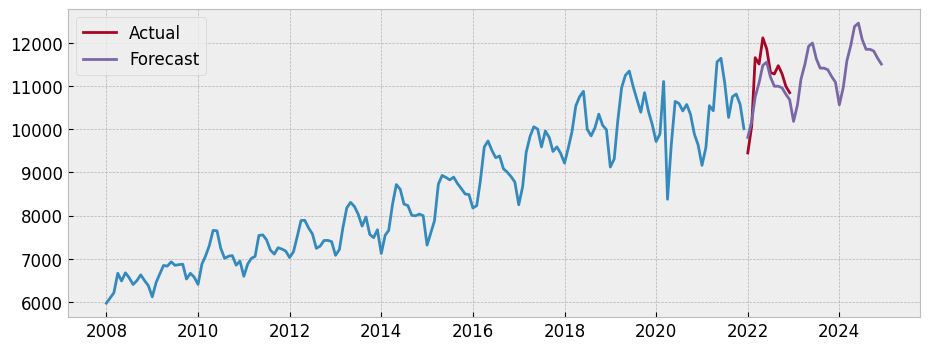

In [124]:
from sktime.forecasting.base import ForecastingHorizon

auto_fore = auto_ets.predict(fh=np.arange(1, 37))

auto_fore.index = ets_MAM_log_fore.index

plot_fore(ts_train_log, ts_test_log, auto_fore, True)

The AutoETS picked the same model that we've used earlier and we end up with the same forecasts.

### ARIMA models

In [324]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss


def test_stationarity(ts, lags=None):
    fig = plt.figure(figsize=(12, 5))
    
    fig.add_subplot(211)
    plt.plot(ts[12:])
    plt.title("Series")
    
    fig.add_subplot(223)
    plot_acf(ts, lags=40, ax=plt.gca())
    
    fig.add_subplot(224)
    plot_pacf(ts, method="ywm", lags=40, ax=plt.gca())
    
    
    plt.tight_layout()
    
    kpss_res = kpss(ts)
    print("KPSS P_value: ", kpss_res[1])
    

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


KPSS P_value:  0.01


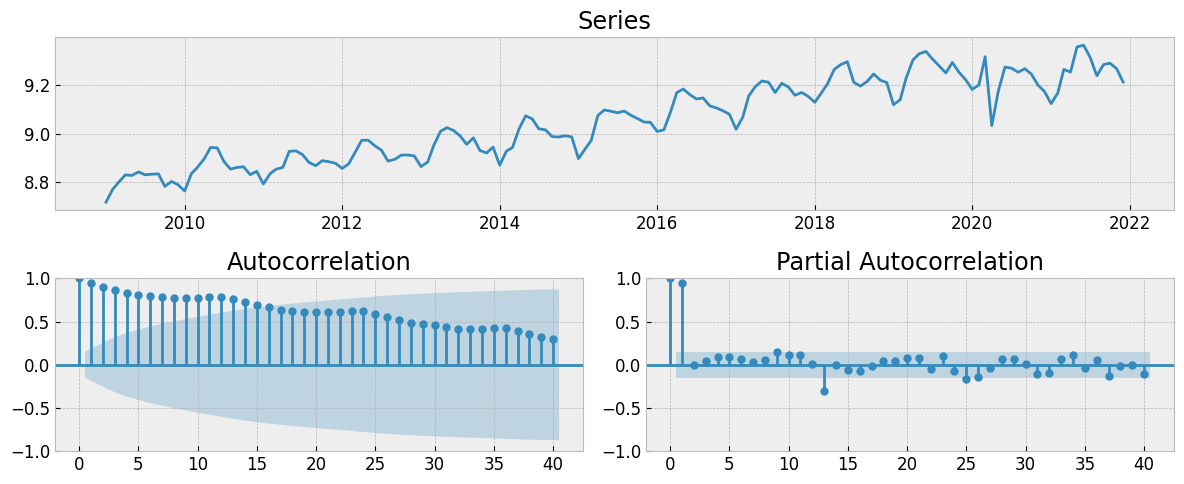

In [298]:
test_stationarity(ts_train_log)

KPSS P_value:  0.1


C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


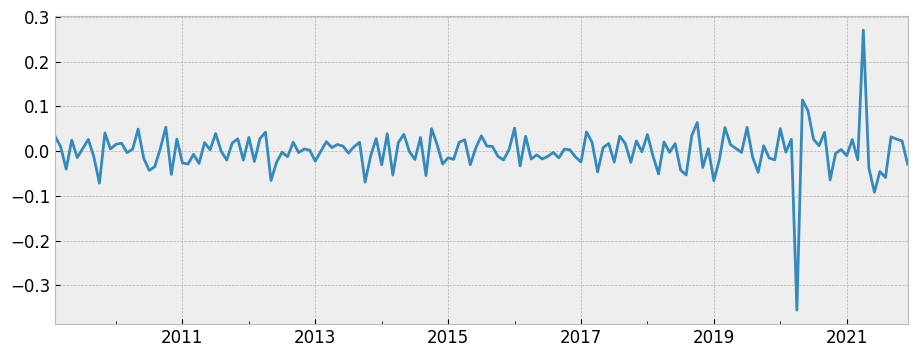

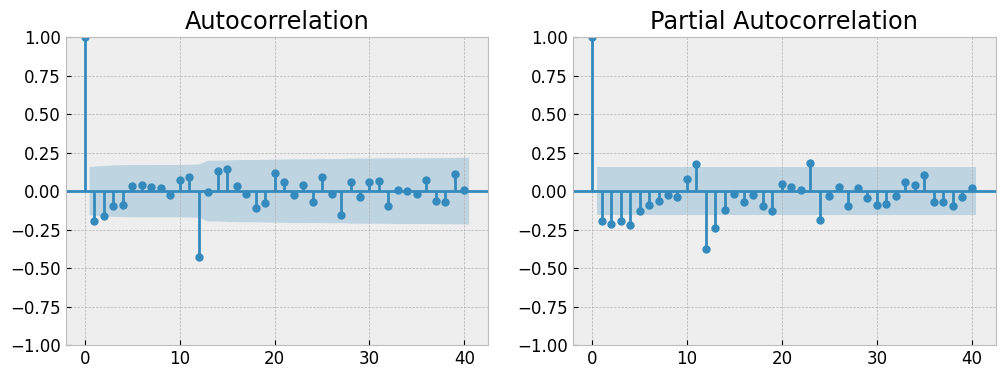

In [127]:
from statsmodels.tsa.statespace.tools import diff

diff_1_1 = diff(ts_train_log, k_diff=1, k_seasonal_diff=1, seasonal_periods=12)
diff_1_1.plot()

test_stationarity(diff_1_1)

After one regular first order differencing and one seasonal differencing, we see in the top graph that the time series looks fairly stationary. <br>
The KPSS test returns a P-value of greater than 0.1, indicating that we have a stationary series after the differencing. <br>
The ACF plot suggests an MA(2) model and a seasonal MA(1) <br>
The PACF plot suggests an AR(4) model and a seasonal AR(1) or AR(2) model

In [128]:
from statsmodels.tsa.arima.model import ARIMA

def make_arima(y, p=0, d=0, q=0, P=0, D=0, Q=0, S=12, print_res=True):
    model = ARIMA(y, order=(p,d,q), seasonal_order=(P,D,Q,S))
    res = model.fit()
    if print_res:
        print(res.summary())
    return res 


In [129]:
arima_410_110 = make_arima(ts_train_log, p=4, d=1, P=1, D=1)
print("############################################################################################")
arima_410_210 = make_arima(ts_train_log, p=4, d=1, P=2, D=1)
print("############################################################################################")
arima_012_011 = make_arima(ts_train_log, q=2, d=1, Q=1, D=1)

                                    SARIMAX Results                                     
Dep. Variable:                          mw_peak   No. Observations:                  168
Model:             ARIMA(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 286.017
Date:                          Sun, 06 Aug 2023   AIC                           -560.034
Time:                                  21:54:09   BIC                           -541.774
Sample:                              01-01-2008   HQIC                          -552.617
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4081      0.133     -3.077      0.002      -0.668      -0.148
ar.L2         -0.3226      0.099     -3.251      0.

**from our results the model with the lowest AIC is the ARIMA(0,1,2)(0,1,1)12 model**

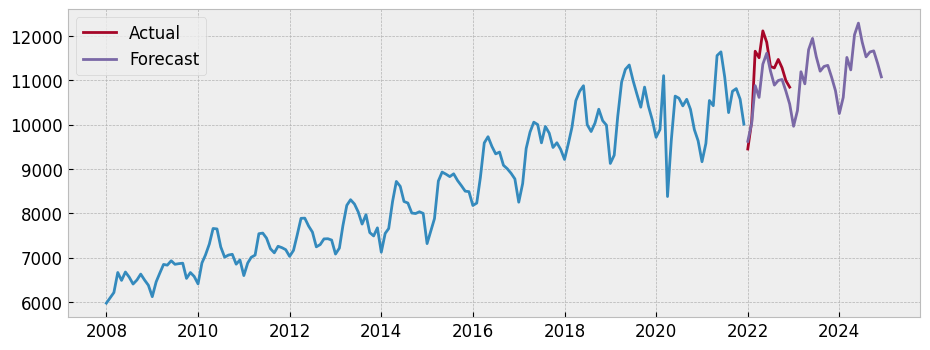

In [130]:
arima_preds = arima_012_011.forecast(36)
plot_fore(ts_train_log, ts_test_log, arima_preds, True)

The forecasts roughly looks the same as our ETS(M,A,M) model

In [131]:
from  pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(m=12)
auto_arima.fit(ts_train_log)

print(auto_arima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 320.196
Date:                            Sun, 06 Aug 2023   AIC                           -628.392
Time:                                    21:54:40   BIC                           -609.684
Sample:                                01-01-2008   HQIC                          -620.798
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.806e-05      0.000      0.672      0.502      -0.000       0.000
ar.L1          0.4529      0.156   

The best model found by the autoARIMA algorithm is an ARIMA(1,1,1)(1,0,1)12 model. Though we cannot compare the AIC of this model to the previous three that we've tried since they have different order of differencing.

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


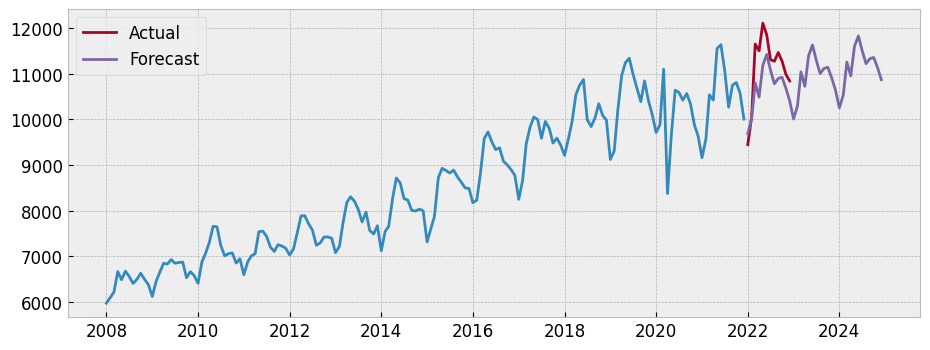

In [132]:
arima_111_101 = make_arima(y=ts_train_log, p=1, d=1, q=1, P=1, Q=1, print_res=False)
arima_111_101_fore = arima_111_101.forecast(36)

plot_fore(ts_train_log, ts_test_log, arima_111_101_fore, True)

The predictions of the model found by the automated algorithms look worse than the predictions made by our manually crafted models.

<AxesSubplot: >

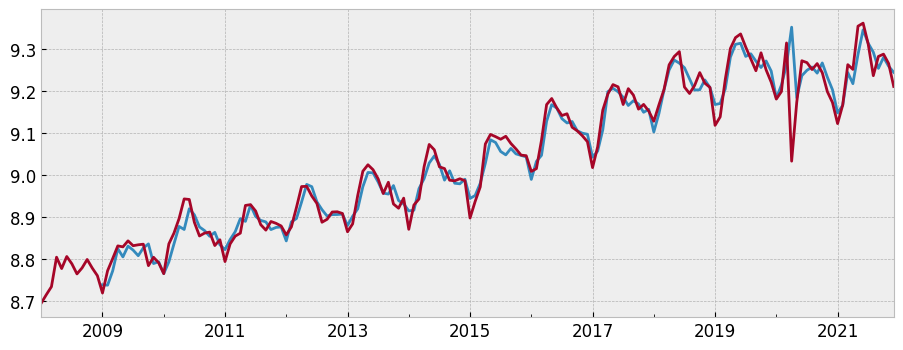

In [133]:
in_sample2 = arima_111_101.predict()
in_sample2.iloc[12:].plot()
ts_train_log.plot()

Let's try to replace the values from the year 2020 with the arima forecast and train our models on this modified time series instead to see if it makes any difference. This method of handling outliers is discussed by Hyndman et al. on the link below. <br>
https://otexts.com/fpp3/missing-outliers.html

<AxesSubplot: >

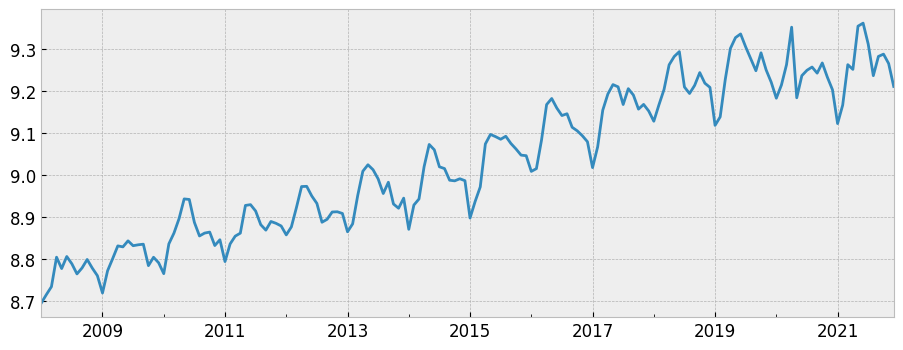

In [134]:
ts_train_log_mod = ts_train_log.copy()
ts_train_log_mod[ts_train_log.index.year == 2020] = in_sample2[in_sample2.index.year == 2020]
ts_train_log_mod.plot()

We see that the modified time series looks a bit better when we replaced the 2020 values.

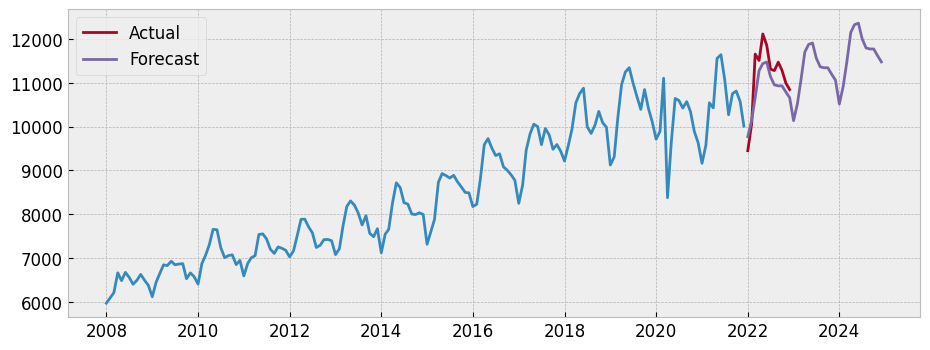

In [135]:
ets_MAM2 = ETSModel(ts_train_log_mod,
                   error="mul",
                   trend="add",
                   damped_trend=False,
                   seasonal="mul",
                   seasonal_periods=12)

ets_MAM2_model =ets_MAM2.fit()
MAM2_fore = ets_MAM2_model.forecast(36)
plot_fore(ts_train_log, ts_test_log, MAM2_fore, True)


In [136]:
#Let's run another autoARIMA on the augmented dataset
auto_arima2 = AutoARIMA(m=12)
auto_arima_2 = auto_arima2.fit(ts_train_log_mod)

print(auto_arima2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 351.555
Date:                            Sun, 06 Aug 2023   AIC                           -693.109
Time:                                    21:55:30   BIC                           -677.519
Sample:                                01-01-2008   HQIC                          -686.781
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.140      2.954      0.003       0.139       0.689
ma.L1         -0.8463      0.073   

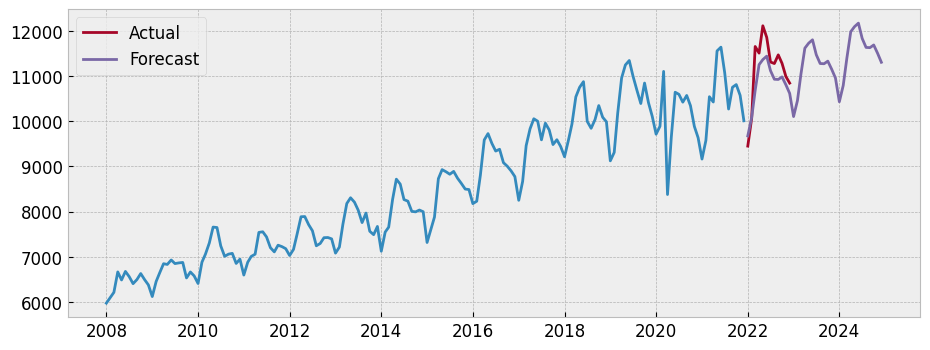

In [137]:
auto_arima_2_fore = auto_arima_2.predict(n_periods=36)
plot_fore(ts_train_log, ts_test_log, auto_arima_2_fore, True)

Our fix didn't help much as we see in the forecast of the ETS and ARIMA model. They look a bit better but the forecast on the level is just wrong. <br><br>
We've hit a limitation with ETS and ARIMA models in our dataset. The primary reason is the effect of the pandemic in the year 2020, which caused a sudden shift in level and trend which our models couldn't properly adapt to. If this anomaly happened in the past, then we could probably truncate it altogether. <br><br>
Let's now try to use exogenous regressors to see if it could fix our forecasts.

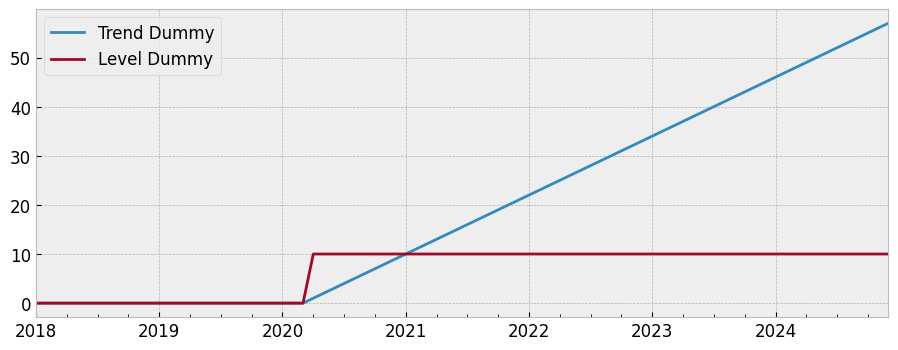

In [139]:
dates_2 = pd.date_range(start="2008-01-01", end="2024-12-01", freq="MS")
dates_with_trend = pd.date_range(start="2020-03-01", end="2024-12-01", freq="MS")

trend_change = pd.Series(np.zeros(len(dates_2)), index=dates_2)
trend_change[trend_change.index >= "2020-03-01"] = np.arange(len(dates_with_trend))

trend_change[trend_change.index.year >= 2018].plot(label="Trend Dummy")

level_change = trend_change.copy()
level_change[level_change.index > "2020-03-01"] = 1
#Multiply it by 10 just for plotting
(level_change[level_change.index.year >= 2018] * 10).plot(label="Level Dummy")
plt.legend()



In [140]:
df_exog = pd.DataFrame([trend_change, level_change]).T
df_exog.columns = ["Trend Dummy", "Level Dummy"]

exog_train = df_exog[df_exog.index.year < 2022]
exog_test = df_exog[df_exog.index.year == 2022]
exog_fore = df_exog[df_exog.index.year >= 2022]

                                     SARIMAX Results                                      
Dep. Variable:                            mw_peak   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 356.553
Date:                            Sun, 06 Aug 2023   AIC                           -699.106
Time:                                    21:55:50   BIC                           -677.280
Sample:                                01-01-2008   HQIC                          -690.247
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Trend Dummy     0.0079      0.004      2.256      0.024       0.001       0.015
Level Dummy    -0.2858      0.01

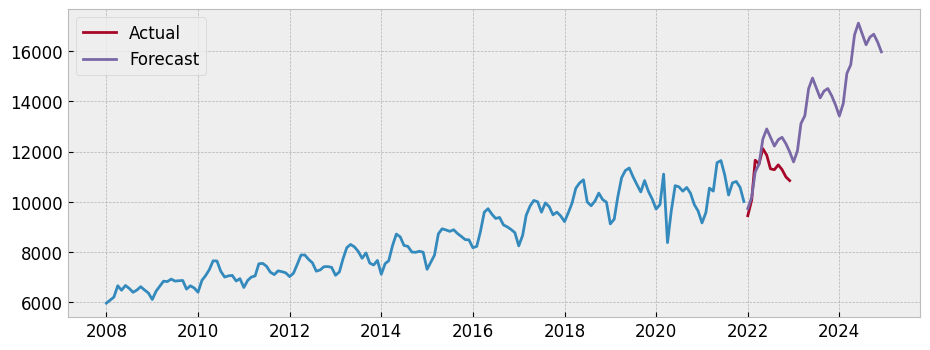

In [141]:
# Let's fit an ARIMA(1,1,1)(1,0,1)12 

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(ts_train_log,
                 exog=exog_train,
                 order=(1,1,1),
                 seasonal_order=(1,0,1,12),
                 )

sarimax_model = sarimax.fit(maxiter=200)

print(sarimax_model.summary())
sarimax_fore = sarimax_model.forecast(36, exog=exog_fore)
plot_fore(ts_train_log, ts_test_log, sarimax_fore, True)

The effect is disastrous on the forecast, the model is now severly over-forecasting the trend. This is probably due to the combined effect of the differencing and the trend exogenous variable. Let's try to exclude the trend variable and refit the model.

                                     SARIMAX Results                                      
Dep. Variable:                            mw_peak   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 354.372
Date:                            Sun, 06 Aug 2023   AIC                           -696.744
Time:                                    21:55:57   BIC                           -678.036
Sample:                                01-01-2008   HQIC                          -689.150
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Level Dummy    -0.2817      0.015    -19.021      0.000      -0.311      -0.253
ar.L1           0.7722      0.10

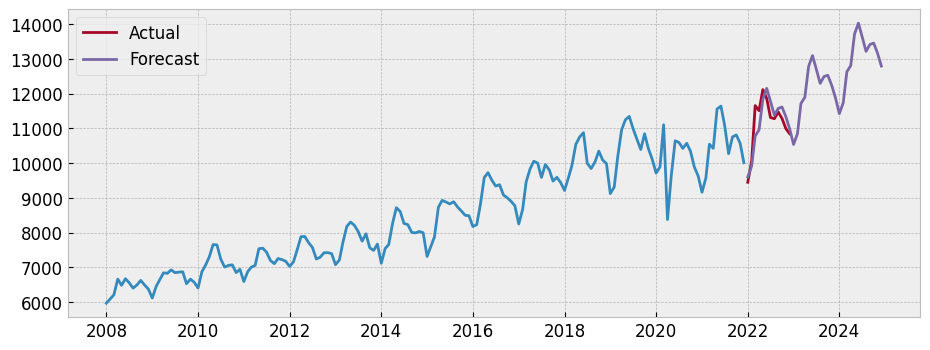

In [142]:
exog_train2 = exog_train["Level Dummy"]
exog_fore2 = exog_fore["Level Dummy"]

sarimax2 = SARIMAX(ts_train_log,
                 exog=exog_train2,
                 order=(1,1,1),
                 seasonal_order=(1,0,1,12),
                 )

sarimax_model2 = sarimax2.fit(maxiter=200)

print(sarimax_model2.summary())
sarimax_fore2 = sarimax_model2.forecast(36, exog=exog_fore2)
plot_fore(ts_train_log, ts_test_log, sarimax_fore2, True)

So we only needed the level trend variable in order to negate the effects of the pandemic.

KPSS P_value:  0.1


C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


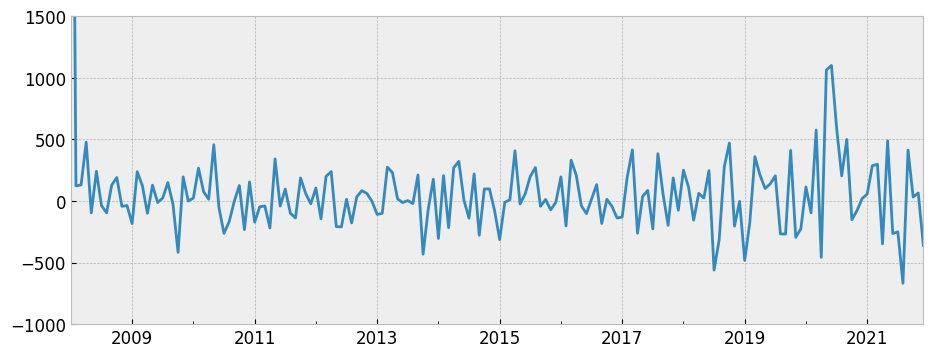

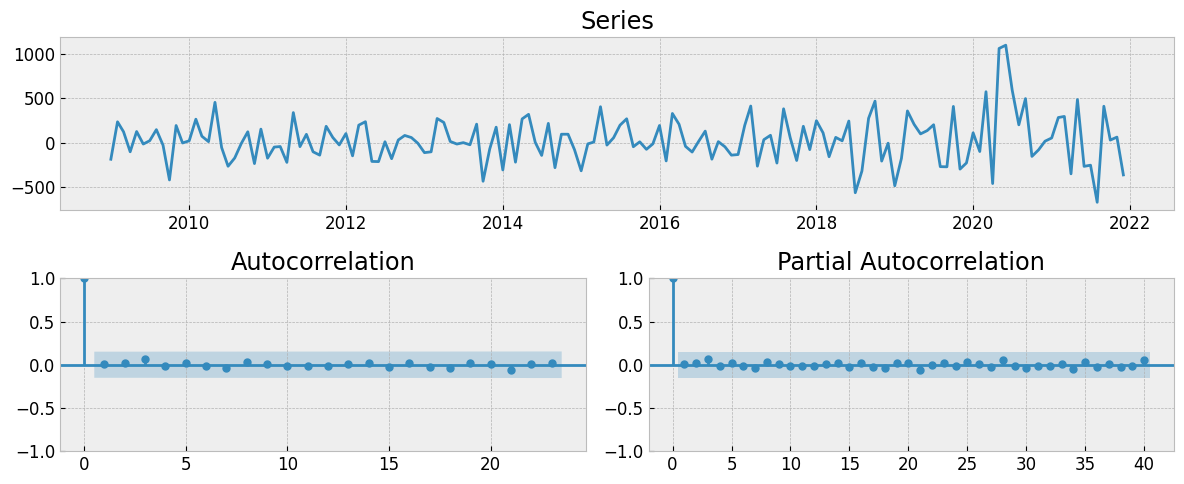

In [320]:
smx2_preds = sarimax_model2.predict()
res = np.e**ts_train_log - np.e**smx2_preds
res.plot()
plt.ylim(-1000, 1500)
test_stationarity(res)


The residuals looks good and the kpss test returns not significant, which means that the residuals are stationary.

In [304]:
#fit the whole dataset and produce 3 year forecast

ts_log = np.log(ts)
time_horizon = 3
exog_ = pd.DataFrame(np.zeros(len(ts) + time_horizon * 12))
exog_.index = pd.date_range(start="2008-01-01", freq="MS", periods=(len(ts) + time_horizon * 12))
exog_.columns = ["pandemic_shock"]

exog_[exog_.index >= "2020-03-01"] = 1
exog_train = exog_[exog_.index.year <= 2022]
exog_test = exog_[exog_.index.year > 2022]




In [147]:
final_model = SARIMAX(ts_log,
                     exog=exog_train,
                     order=(1,1,1),
                     seasonal_order=(1,0,1,12)).fit(maxiter=200)
final_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            mw_peak   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 349.582
Date:                            Sun, 06 Aug 2023   AIC                           -687.164
Time:                                    21:56:24   BIC                           -668.039
Sample:                                01-01-2008   HQIC                          -679.409
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
pandemic_shock    -0.0888      0.008    -11.533      0.000      -0.104      -0.074
ar.L1              0.2657      0.114      2.329      0.020       0.042       0.489
ma.L1             -0.8884      0.059    -15.072      0.000      -1.004      -0.773
ar.S.L12           0.9793      0.019     50.222      0.000       0.941       1.018
ma.S.L12          -0.7106      0.095     -7.510      0.000      -0.896      -0.525
sigma2             0.0011   8.65e-05     12.241      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              5262.99
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                            -2.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P_value:  0.1


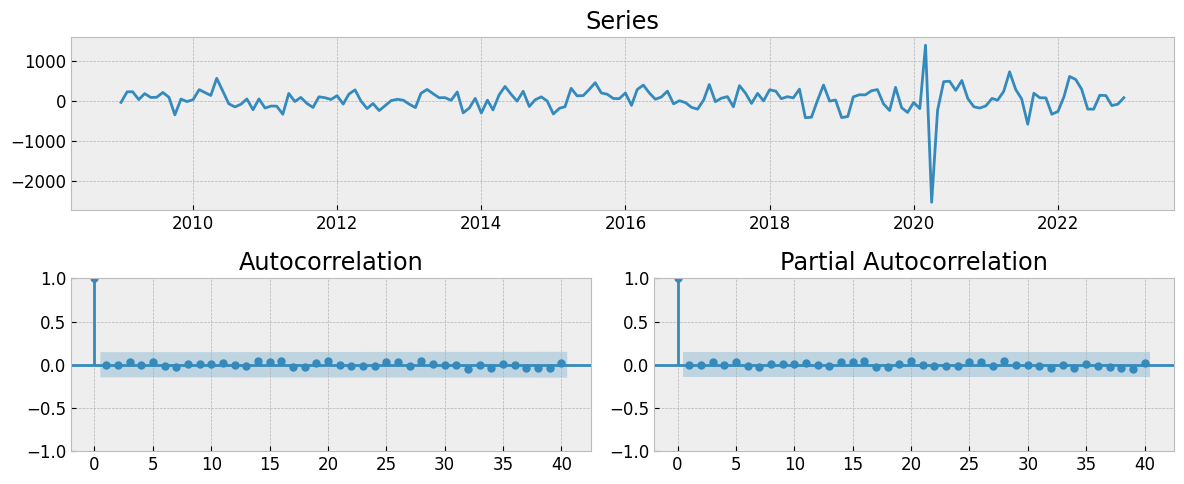

In [301]:
final_model_preds = np.e ** final_model.predict()
resids  =  ts - final_model_preds

test_stationarity(resids)

The residuals looks fairly good and the KPSS test results agree with our conclusion.

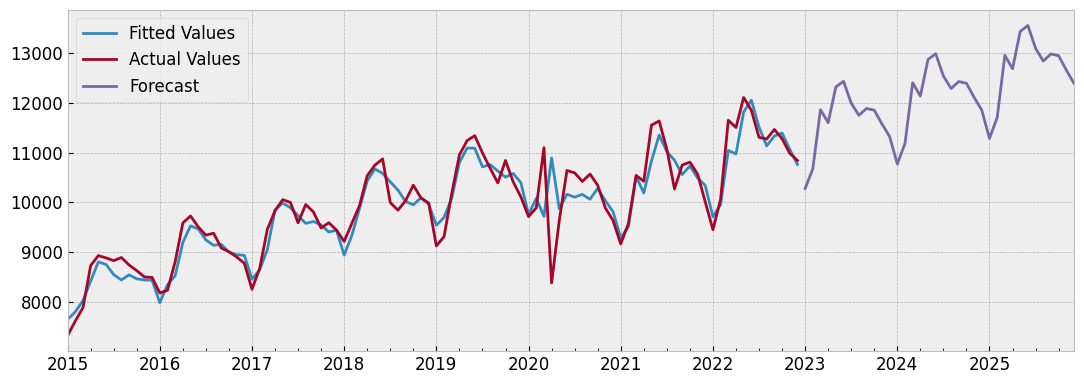

In [149]:
forecast = np.e**final_model.forecast(36, exog=exog_test)
final_model_preds[final_model_preds.index.year >= 2015].plot(label="Fitted Values")
ts[ts.index.year >= 2015].plot(label="Actual Values")
forecast.plot(label="Forecast")

plt.legend()
plt.tight_layout()

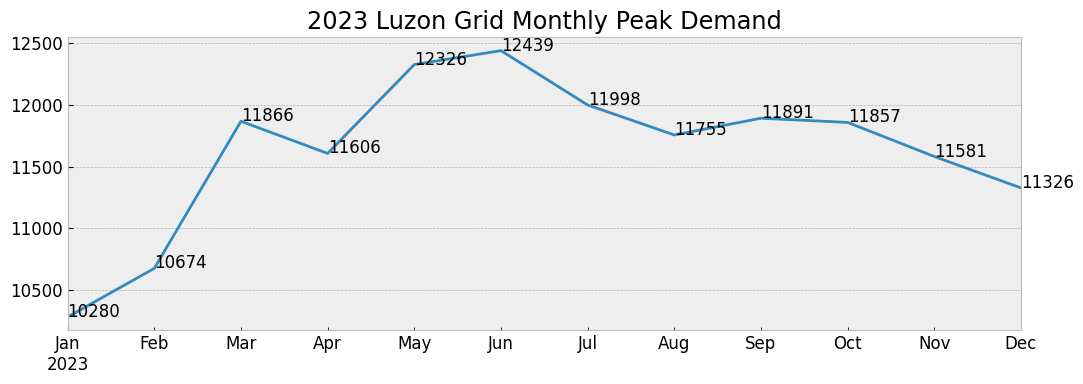

In [150]:
fore2023 = forecast[forecast.index.year == 2023]
fore2023.plot()
ax = plt.gca()

for i, val in enumerate(fore2023):
    ax.annotate(int(val), (fore2023.index[i], fore2023[i]))
    
ax.set_title("2023 Luzon Grid Monthly Peak Demand")
plt.tight_layout()

Text(0.5, 1.0, 'Forecast With 80% CI')

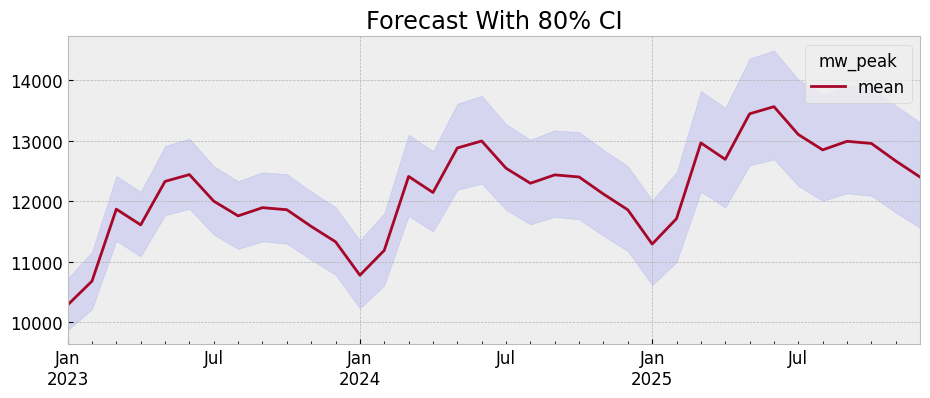

In [151]:
summary_frame = np.e ** final_model.get_forecast(36, exog=exog_test).summary_frame(alpha=0.2)
summary_frame[["mean"]].plot(color="C1")
ax2 = plt.gca()
ax2.fill_between(summary_frame.index, summary_frame.mean_ci_lower, summary_frame.mean_ci_upper, color="blue", alpha=0.1)
ax2.set_title("Forecast With 80% CI")

## Exogenous Regressors

We will now include exogenous regressors such as temperature improve forecasts.

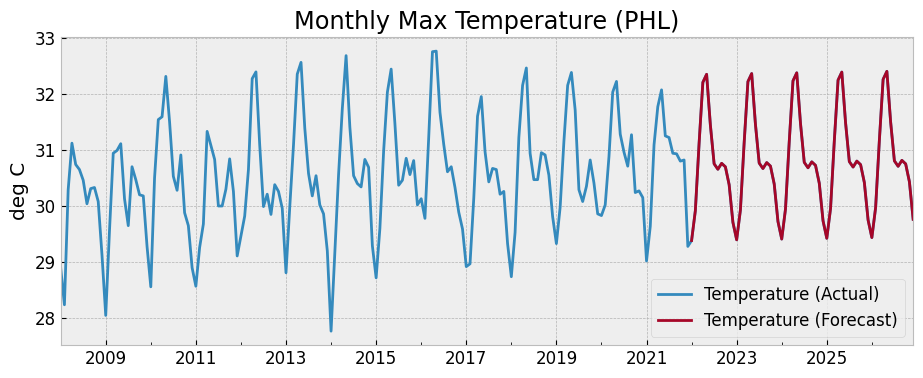

In [248]:
temp_file = "tempmax_PHL_1901-2021.csv"

def load_data(file_name, start="1901-01-01"):
    
    path = os.path.join(os.path.realpath(".."), "datasets", file_name)
    df = pd.read_csv(path, skiprows=2, index_col=0)
    
    df_np = df.to_numpy().flatten().reshape(-1, 1)
    
    idx = pd.date_range(start=start, freq="MS", periods=len(df_np))
    df = pd.DataFrame(df_np, columns=["max_temp"], index=idx)
    
    return df

temp_df = load_data("tempmax_PHL_1901-2021.csv")
temp_df = temp_df[temp_df.index.year >= 2008]
max_temp = temp_df.max_temp

temp_fore = pd.read_csv(os.path.join(os.path.realpath(".."), "datasets", "Phl_maxtemp_forecast.csv"), 
                        index_col=0, 
                        parse_dates=True).max_temp

max_temp_ts = list(max_temp) + list(temp_fore)

idx = pd.date_range(start="2008-01-01", freq="MS", periods=len(max_temp_ts))

max_temp_ts = pd.Series(max_temp_ts, index=idx)
max_temp_ts.plot(label="Temperature (Actual)")
max_temp_ts[max_temp_ts.index.year >= 2022].plot(label="Temperature (Forecast)", color="C1")

plt.ylabel("deg C")
plt.title("Monthly Max Temperature (PHL)")
plt.legend()
plt.show()

We will use monthly maximum temperature as exogenous regressors. The temperature data used in the forecasting part is generated by another forecasting model.

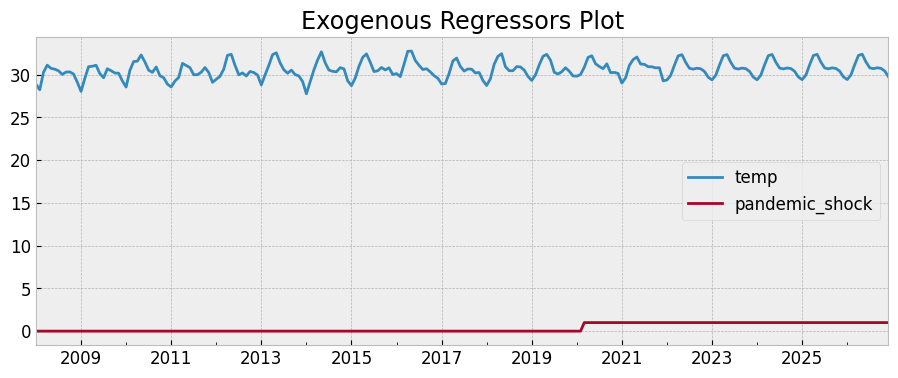

In [250]:
def create_exog(exog, start_date="2008-01-01", shock_date="2020-03-01"):
    idx = pd.date_range(start=start_date, freq="MS", periods=len(exog))
    
    df = pd.DataFrame()
    
    df["temp"] = exog
    df.index = idx
    
    df["pandemic_shock"] = np.zeros(len(exog))
    df.pandemic_shock[df.index >= shock_date] = 1
    
    return df

exog_df = create_exog(max_temp_ts)

exog_df.plot()
plt.title("Exogenous Regressors Plot")
plt.show()

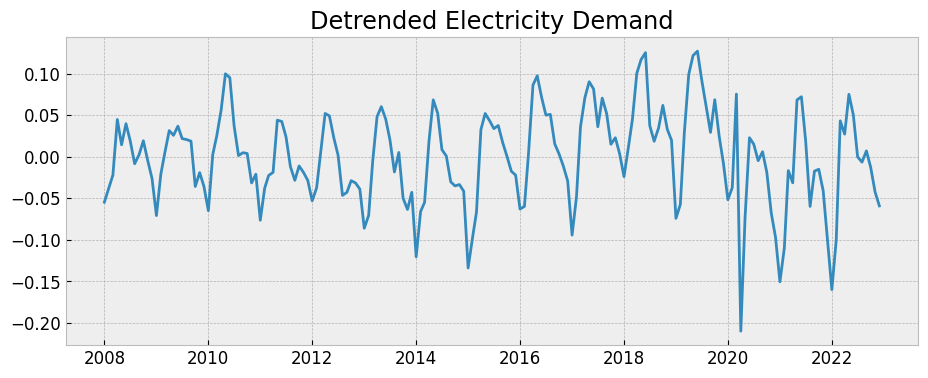

In [253]:
from sklearn.linear_model import LinearRegression
x_trend = np.arange(len(ts_log)).reshape(-1, 1)

lm = LinearRegression().fit(x_trend, ts_log)

detrend_ts = ts_log - lm.predict(x_trend) 
plt.plot(detrend_ts)
plt.title("Detrended Electricity Demand")
plt.show()

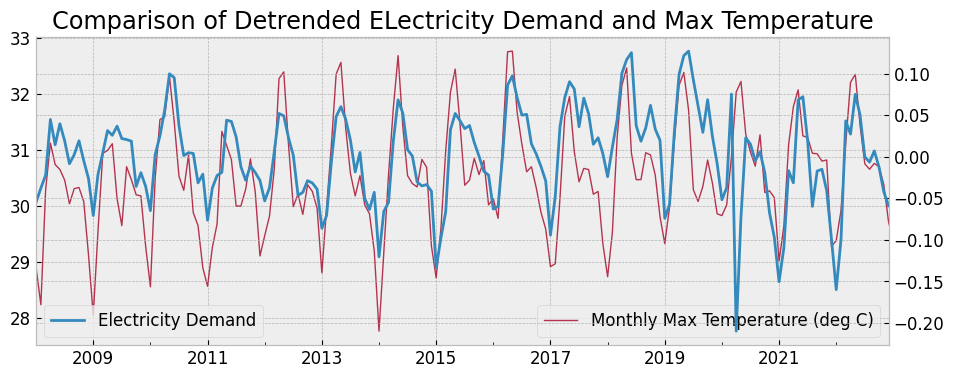

In [257]:
fig = plt.figure()
ax = fig.add_subplot()
max_temp_ts["2008-01-01":"2023-01-01"].plot(label="Monthly Max Temperature (deg C)", 
                                            ax=ax, 
                                            color="C1", 
                                            alpha=0.8, 
                                            linewidth=1)
plt.legend()

ax2 = ax.twinx()
detrend_ts.plot(label="Electricity Demand", ax=ax2)

plt.title("Comparison of Detrended ELectricity Demand and Max Temperature")
plt.legend()

We see from the plot that the electrical demand and the monthly max temperature are somewhat correlated.

In [262]:
train_exog2 = exog_df[exog_df.index.year < 2022]
test_exog2 = exog_df[exog_df.index.year == 2022]

In [264]:
exog_model2 = SARIMAX(ts_log[ts_log.index.year != 2022],
                     exog=train_exog2,
                     order=(1,1,1),
                     seasonal_order=(1,0,1,12)).fit(maxiter=200)
exog_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            mw_peak   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 331.673
Date:                            Sun, 06 Aug 2023   AIC                           -649.346
Time:                                    23:18:23   BIC                           -627.520
Sample:                                01-01-2008   HQIC                          -640.487
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
temp               0.0250      0.008      3.036      0.002       0.009       0.041
pandemic_shock    -0.0853      0.008    -10.901      0.000      -0.101      -0.070
ar.L1              0.1406      0.093      1.513      0.130      -0.042       0.323
ma.L1             -0.8443      0.071    -11.923      0.000      -0.983      -0.706
ar.S.L12           0.9592      0.041     23.179      0.000       0.878       1.040
ma.S.L12          -0.7066      0.126     -5.619      0.000      -0.953      -0.460
sigma2             0.0010   7.38e-05     13.865      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              4506.55
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               5.97   Skew:                            -2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE:  298.86173943730927


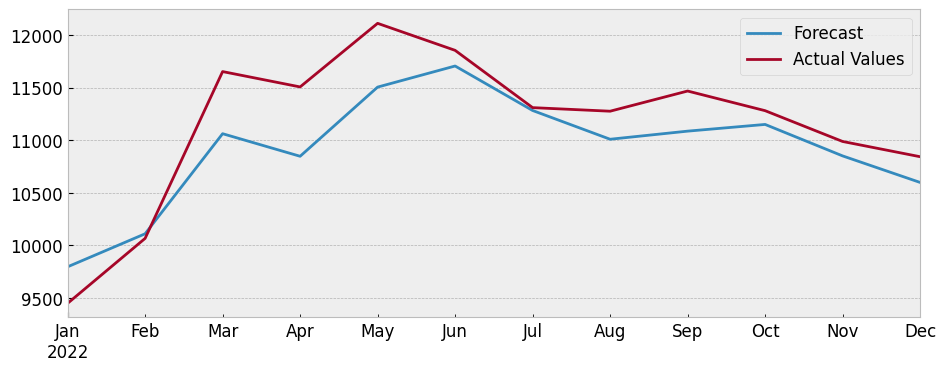

In [303]:
from sklearn.metrics import mean_absolute_error as mae

exog_fore2 = np.e ** exog_model.forecast(steps=12, exog=test_exog2)
exog_fore2.plot(label="Forecast")
ts[ts_log.index.year == 2022].plot(label="Actual Values")
plt.legend()
print("MAE: ", mae(ts[ts_log.index.year == 2022], exog_fore2))

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P_value:  0.1


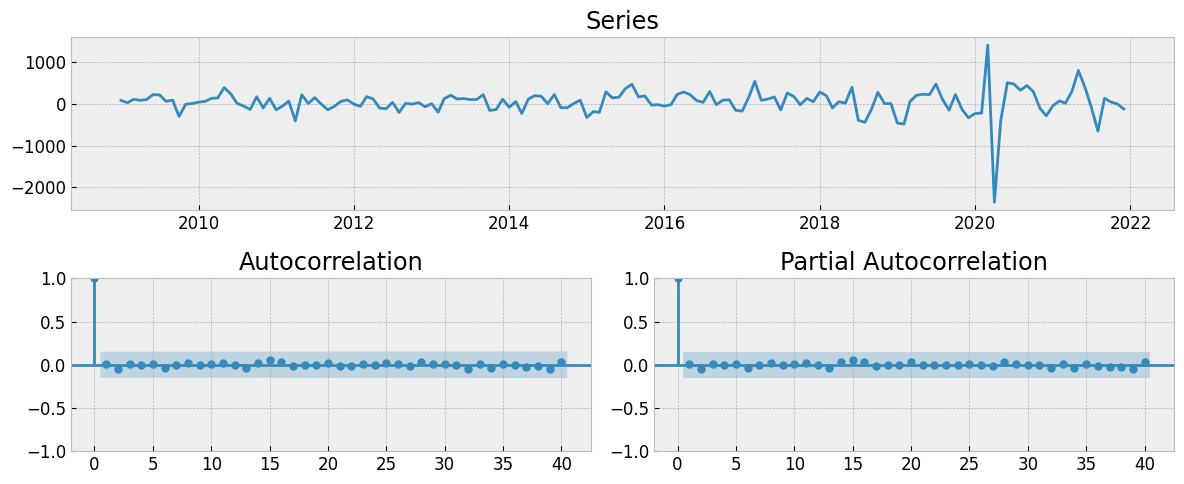

In [302]:
exog_pred2 = exog_model2.predict()
exog_resids2 = np.e ** train_ts - np.e ** exog_pred2

test_stationarity(exog_resids)

In [308]:
exog_model_auto = AutoARIMA(m=12).fit(ts_log[ts_log.index.year != 2022], train_exog2)
exog_model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 12)   Log Likelihood                 334.660
Date:                              Sun, 06 Aug 2023   AIC                           -647.320
Time:                                      23:38:39   BIC                           -613.022
Sample:                                  01-01-2008   HQIC                          -633.399
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0013      0.053      0.025      0.980      -0.102       0.105
temp               0.0270      0.008      3.248      0.001       0.011       0.043
pandemic_shock    -0.0831      0.009     -9.044      0.000      -0.101      -0.065
ar.L1             -0.5820     73.483     -0.008      0.994    -144.607     143.443
ar.L2              0.1886     17.114      0.011      0.991     -33.353      33.731
ma.L1             -0.1176     73.495     -0.002      0.999    -144.165     143.929
ma.L2             -0.7583     68.489     -0.011      0.991    -134.995     133.478
ar.S.L12           0.5469      0.603      0.907      0.364      -0.635       1.729
ar.S.L24           0.1876      0.346      0.543      0.587      -0.490       0.865
ma.S.L12          -0.2748      0.611     -0.450      0.653      -1.472       0.922
sigma2             0.0010   8.44e-05     12.128      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              4024.66
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               6.33   Skew:                            -2.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [311]:
exog_model_auto1 = SARIMAX(ts_log[ts_log.index.year != 2022], exog=train_exog2,
                           order=(2,1,2),
                           seasonal_order=(2,0,1,12)).fit(maxiter=500)
exog_model_auto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              mw_peak   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 12)   Log Likelihood                 331.714
Date:                              Sun, 06 Aug 2023   AIC                           -643.429
Time:                                      23:41:10   BIC                           -612.249
Sample:                                  01-01-2008   HQIC                          -630.773
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
temp               0.0250      0.009      2.904      0.004       0.008       0.042
pandemic_shock    -0.0853      0.008    -10.354      0.000      -0.101      -0.069
ar.L1             -0.5823      4.130     -0.141      0.888      -8.676       7.511
ar.L2              0.0913      0.651      0.140      0.888      -1.184       1.367
ma.L1             -0.1222      4.135     -0.030      0.976      -8.226       7.982
ma.L2             -0.6070      3.531     -0.172      0.864      -7.528       6.314
ar.S.L12           0.9197      0.294      3.125      0.002       0.343       1.496
ar.S.L24           0.0341      0.234      0.146      0.884      -0.424       0.492
ma.S.L12          -0.6778      0.296     -2.287      0.022      -1.259      -0.097
sigma2             0.0010   7.52e-05     13.603      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              4481.42
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               5.94   Skew:                            -2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE:  302.24610997159306


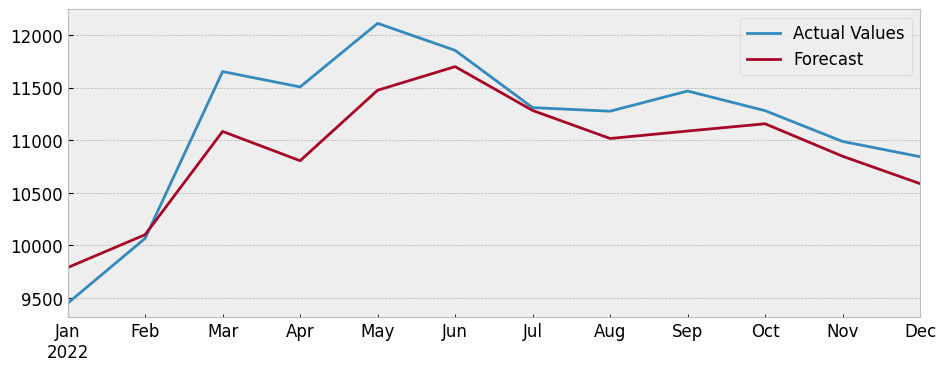

In [328]:
exog_model_auto1_preds = np.e ** exog_model_auto1.forecast(steps=12, exog=test_exog2)

ts[ts.index.year == 2022].plot(label="Actual Values")
exog_model_auto1_preds.plot(label="Forecast")
print("MAE: ", mae(ts[ts.index.year == 2022], exog_model_auto1_preds))
plt.legend()